## Health Care for All Case Study using Pandas

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OneHotEncoder  ##. better to use dummy from pandas 
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import boxcox
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
pd.options.display.max_rows = 50
## Install xlrd package to load Excel files
# conda install openpyxl
## conda install xlrd

<b> loading cleaning data 

In [82]:
hk_df=pd.read_csv("hk_df_cleaned.csv")

In [83]:
hk_df.columns

Index(['state', 'gender', 'median_home_val', 'avg_fam_income',
       'avg_household_income', 'med_fam_income', 'median_household_income',
       'hvp1', 'per_capita_income', 'pobc2', 'avggift', 'domain', 'target_d',
       'med_fam_income_binned'],
      dtype='object')

<b> checking correlations between numerical variables

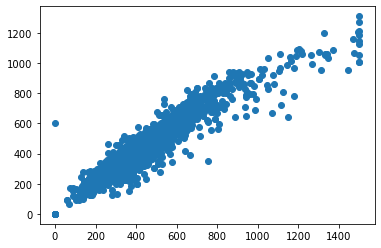

In [84]:
plt.scatter(x=hk_df['med_fam_income'], y=hk_df['avg_household_income'])
plt.show()

In [ ]:
sns.pairplot(hk_df)

<b> plotting the correlation heatmap

In [ ]:
corr = hk_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(9, 7))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

### Highly Correlated Columns

In [ ]:
corr_matrix=hk_df.corr().abs()
upper_triangle=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
[column for column in upper_triangle.columns if any(upper_triangle[column] > 0.80)]

### dropping highly correlated features

In [ ]:
hk_df.drop(["per_capita_income","hvp1","avg_household_income","median_household_income","med_fam_income"],axis=1,inplace=True)

In [ ]:
hk_df

In [ ]:
hk_df.hist(figsize=(12,12))

<b> checking the distribution plot

In [ ]:
sns.distplot((hk_df['median_home_val']), bins=20)

## Data Transformation

Power Transformer: using power transformer to tranform the variable into normal distributionsas it is needed for modeling regression.

In [ ]:
pt = PowerTransformer()
med_home_val_transformed=pt.fit_transform(hk_df['median_home_val'].to_numpy().reshape(-1,1))
sns.displot(med_home_val_transformed)

In [ ]:
pt.lambdas_

In [ ]:
hk_df["med_home_val_transformed"]= med_home_val_transformed
hk_df.drop(["median_home_val"],axis=1,inplace=True)

In [ ]:
hk_df

## Hot coding Categorical Variables 

In [ ]:
categoricals_features= hk_df.select_dtypes("object")
categoricals_features

In [ ]:
#hk_df.state.value_counts()
#hk_df.gender.value_counts()
#hk_df.domain.value_counts()

In [ ]:
categoricals_features=pd.get_dummies(categoricals_features[["gender"]], drop_first=True)
categoricals_features

### Predictive Modeling

<b> X Y split

In [ ]:
X=hk_df.drop('target_d', axis=1)
y=hk_df.target_d

In [ ]:
X=X._get_numeric_data()
X

In [ ]:
## adding categorical features
#X=pd.concat([X,categorical_cols],axis=1)

In [ ]:
X.hist(figsize=(14,14))

<b>Data Splitting

In [ ]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=.30,random_state=123)

<b> Standardize 

In [ ]:
std_scaler=StandardScaler().fit(X_train)   ##. finding the parameters ( mean, variance from the training set )

X_train_scaled=std_scaler.transform(X_train)

In [ ]:
X_train.shape

In [ ]:
X_test_scaled=std_scaler.transform(X_test)

In [ ]:
print(X_train_scaled)
print("--------")
print(X_test_scaled)

## Apply Linear Regression

### Modeling using Statsmodels

In [ ]:
X_train_const_scaled = sm.add_constant(X_train_scaled) # adding a constant

model = sm.OLS(y_train, X_train_const_scaled).fit()
predictions_train = model.predict(X_train_const_scaled) 

X_test_const_scaled = sm.add_constant(X_test_scaled) # adding a constant
predictions_test = model.predict(X_test_const_scaled) 
print_model = model.summary()
print(print_model)

In [ ]:
predictions_test

In [ ]:
#display adjusted R-squared
print(model.rsquared_adj)

### Modeling using Scikit Learn

Model fitting

In [ ]:
model=LinearRegression()    # model
model.fit(X_train_scaled, y_train)   # model train

<b> model parameters  ( b1,b2,b3,b4)

In [ ]:
X_train

In [ ]:
model.coef_

In [ ]:
model.intercept_

In [ ]:
#y= 1.34* avg_fam_income  -0.41 * pobc2   +5.45 * avggift  -0.48 * med_home_val_transformed  + 15.66

Making prediction

In [ ]:
y_pred=model.predict(X_test_scaled)   # model prediction

y_pred_train=model.predict(X_train_scaled)

In [ ]:
y_pred

In [ ]:
y_test

## predicting on new data

In [ ]:
np.array(np.array(new_data).reshape(-1,4)).shape

In [ ]:
## new record 
new_data=[400,80,12,0.15]
new_data_scaled=std_scaler.transform(np.array(new_data).reshape(-1,4))

In [ ]:
model.predict(new_data_scaled)

## Evaluating Model Performance

In [ ]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

In [ ]:
# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A stright line

fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

ax[2].plot(y_pred,y_test - y_pred,"o")
ax[2].set_xlabel("predited")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

<b>more fancy using seaborn

In [ ]:
sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})

<b> Error metrics

In [ ]:
print(mse(y_test,y_pred_test))
print(mae(y_test,y_pred_test))

In [ ]:
##prediction on the train set
mse(y_train,y_pred_train)

In [ ]:
R2=r2_score(y_test,y_pred)
R2

In [ ]:
R2_test=model.score(X_test_scaled,y_test)
R2_train=model.score(X_train_scaled,y_train)

In [ ]:
Adj_R2= 1 - (1-R2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
Adj_R2

## getting the number of parameters 

In [ ]:
X_test.shape[1]

#### Feature Importance

In [ ]:
features_importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': abs(model.coef_)
})
features_importances = features_importances.sort_values(by='Importance', ascending=False)

In [ ]:
features_importances

In [ ]:
plt.bar(x=features_importances['Attribute'], height=features_importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

#### Write a csv

With `to_csv` 

In [ ]:
hk_df.to_csv("Data/healthcare_for_all_transformed_data.csv")